In [20]:
%matplotlib notebook
from sympy import *
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import statistics
from fractions import Fraction
mc =40.0*1.66e-27 #calcium
mh=44.0*1.66e-27
kb = 1.380e-23 #ボルツマン定数
Tk = 500e-6 # 
T = 500   #初期温度
d=8 #deg#rotating angle
rad=(d/180)*2*pi #radian
vy0=(kb*T/mc)**0.5*10e-3 #初期速度
#vy = (kb*Tk/m)**0.5 #イオンが振動している速さ
wy = 2*pi*400e3 #y方向の永年周波数
#レーザー冷却項に必要な定数
hbar = 1.054e-34 #J.s
h = 2*pi*hbar
c = 3.0e8
Gamma=2*pi*20.7e6   #Hz
tau=1/Gamma #寿命

lamda = 397e-9 #nm,冷却レーザーの波長
delta=2*pi*10e6   #detuning#Hz#delta-omega
k=2*pi/lamda
dg = -0.5 #δ/Γ
I = 50e-6/(pi*(100e-6)**2)
Isat = (pi/3)*(h*c)/(tau*lamda**3)
s=Ir=0.5
a = (4*hbar*k**2)*Ir*(-2*dg)/((1+(2*dg)**2)**2)/mc
y0=-50e-6
whx=wcx= 2*pi*1500e3
why=wcy= 2*pi*1000e3
whz=wcz=2*pi*400e3
g=Gamma
e=1.6021e-19 #C
F=e**2/(4*pi)
epsilon0=8.854e-12  #[F/m]
g*mc

2.74896e-18*pi

In [57]:
# 初期値、変数の定義
m = np.array((mh, mh, mh, mc, mc, mc))     # 各自由度の質量 (m1, m2, m3, ... , mn)
c = np.array((0, 0, 0, mc*g, mc*g, mc*g)) # 各自由度の減衰係数 (c1, c2, c3, ... , cn)
k = np.array((whx, why, whz, wcx, wcy, wcz))    # 各自由度の弾性係数(剛性) (k1, k2, k3, ... , kn)
n = len(m)                    # 自由度
x_0 = np.array((10e-6, -50e-6, 20e-6, 0, 0, 0,))  # 変位の初期値
v_0 = np.array((0, 100, 0, 0,0, 0,))     # 速度の初期値
t_max = 1e-5# 終了時間
dt = 1e-8               # サンプリング間隔
t = np.arange(0, t_max, dt)       # 時間データ
F=e**2/(4*pi*epsilon0)
x_0

array([ 1.e-05, -5.e-05,  2.e-05,  0.e+00,  0.e+00,  0.e+00])

In [58]:
# 運動方程式の関数化

I= np.array((1, 1, 1, 1, 1, 1))  
def func(v, x,):

    '''運動方程式'''
    # 各種変数定義
    n = len(m)                     # 
    M = np.zeros((n, n))           # 
    C = np.zeros((n, n))           # 
    K = np.zeros((n, n))           # 
    H = np.zeros((n, n))           #
    # マトリクスの生成
    C[0][0]= C[1][1]= C[2][2]=0
    C[3][3]=0.7*g*mc
    C[4][4]=0.1*g*mc 
    C[5][5]=1.7*g*mc  ##摩擦力
    H[0][0]= H[3][3]=whx**2
    H[1][1]= H[4][4]=why**2
    H[2][2]= H[5][5]=whz**2
    for i in range(n):
        M[i, i] = m[i]
        d=(abs((x[0]-x[3])**2+(x[1]-x[4])**2+(x[2]-x[5])**2))
        if i <= 2:
             K[i][i] =F*(x[i]-x[i+3])*(d**(-3/2))
        else:
            K[i][i] =F*(x[i-3]-x[i])*(d**(-3/2))
    M_inv = np.linalg.inv(M)       # 質量マトリクスの逆行列
    
    return - M_inv @ C @ v.T + M_inv @ K @ I.T-H @ x.T

In [59]:
# ルンゲクッタ法による数値解析
def runge_kutta_method(n, t, dt, x_0, v_0, func):
    '''ルンゲクッタ法'''
    x = np.zeros((len(t), n))
    v = np.zeros((len(t), n))
    for i in range(len(t) - 1):
        if i == 0:
            x[i, :] = x_0
            v[i, :] = v_0
            
        k1_x = v[i, :] * dt
        k1_v = func(v[i, :], x[i, :]) * dt
        
        k2_x = (v[i, :] + k1_v / 2) * dt
        k2_v = func(v[i, :] + k1_v / 2, x[i, :] + k1_x / 2) * dt
        
        k3_x = (v[i, :] + k2_v / 2) * dt
        k3_v = func(v[i, :] + k2_v / 2, x[i, :] + k2_x / 2) * dt
        
        k4_x = (v[i, :] + k3_v) * dt
        k4_v = func(v[i, :] + k3_v, x[i, :] + k3_x) * dt
        
        x[i + 1, :] = x[i, :] + (k1_x + 2 * k2_x + 2 * k3_x + k4_x) / 6
        v[i + 1, :] = v[i, :] + (k1_v + 2 * k2_v + 2 * k3_v + k4_v) / 6
    return x
x_rk = runge_kutta_method(n, t, dt, x_0, v_0, func)

<IPython.core.display.Javascript object>


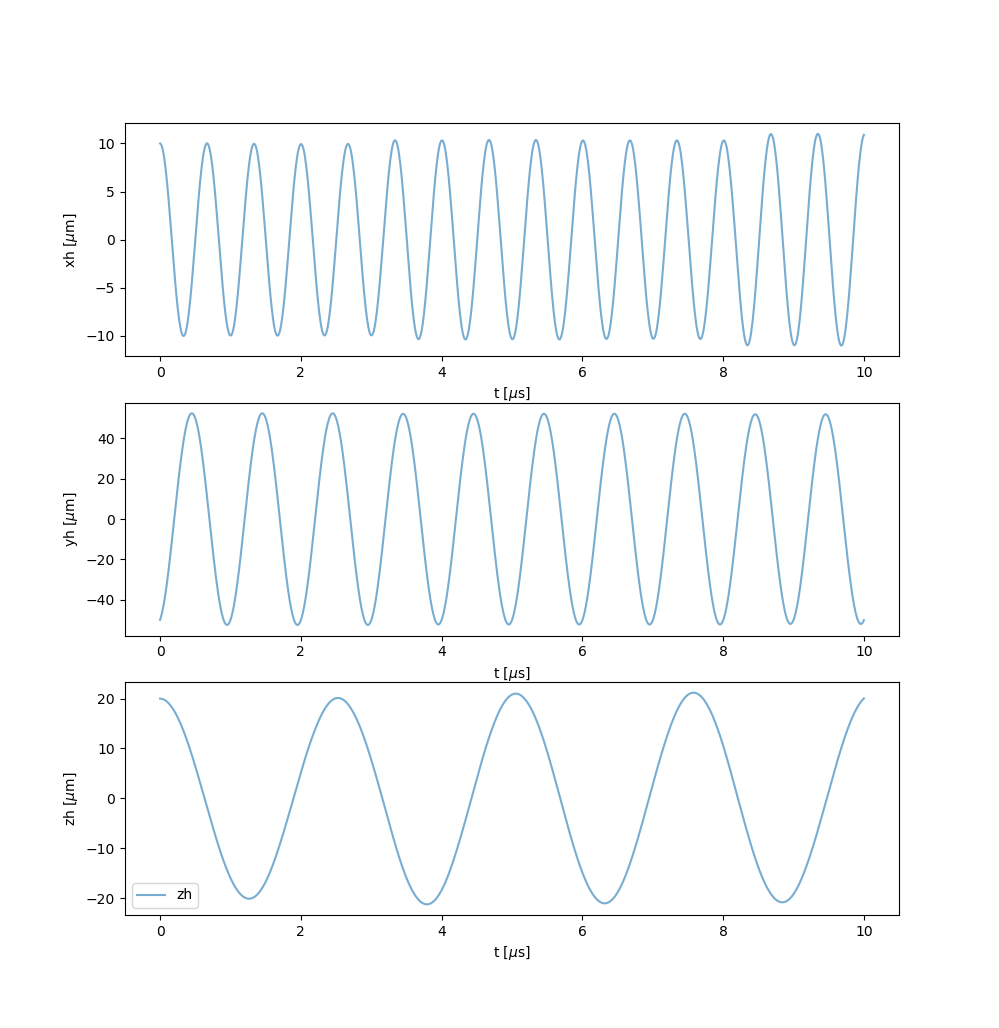

array([[ 1.00000000e-05, -5.00000000e-05,  2.00000000e-05,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.95562942e-06, -4.89020430e-05,  1.99937033e-05,
         8.22619312e-12, -5.11728224e-11,  1.43522051e-11],
       [ 9.82291232e-06, -4.76111914e-05,  1.99748189e-05,
         2.60927123e-11, -1.98527754e-10,  3.25916987e-11],
       ...,
       [ 1.04458365e-05, -5.14578650e-05,  1.97547611e-05,
        -1.84150576e-08, -1.48623021e-09, -1.29402762e-08],
       [ 1.07196892e-05, -5.08826144e-05,  1.99055565e-05,
        -1.82121912e-08, -2.75305638e-09, -1.29189456e-08],
       [ 1.08984130e-05, -5.01066464e-05,  2.00438156e-05,
        -1.80102207e-08, -3.95123269e-09, -1.28970687e-08]])

In [66]:
# プロット
fig = plt.figure(figsize=(12,10))


ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(t*10**6, x_rk[:, 0]*10**6, alpha=0.6,label='xh')
ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(t*10**6, x_rk[:, 1]*10**6, alpha=0.6,label='yh')
ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(t*10**6, x_rk[:, 2]*10**6, alpha=0.6,label='zh')

ax1.set_xlabel('t [$\u03bc$s]')
ax1.set_ylabel('xh [$\u03bc$m]')

ax2.set_xlabel('t [$\u03bc$s]')
ax2.set_ylabel('yh [$\u03bc$m]')

ax3.set_xlabel('t [$\u03bc$s]')
ax3.set_ylabel('zh [$\u03bc$m]')
plt.legend(loc='best')
plt.show()
plt.savefig("sympathetic-cooling-short-time")
x_rk

<IPython.core.display.Javascript object>


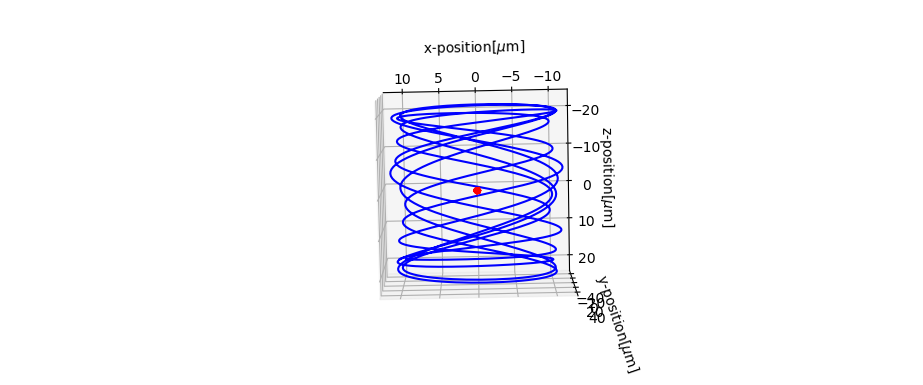

In [69]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot( x_rk[:, 0]*10**6,  x_rk[:, 2]*10**6, x_rk[:, 1]*10**6, color='blue')
ax.plot( x_rk[:, 3]*10**6,  x_rk[:, 5]*10**6, x_rk[:, 4]*10**6,linewidth=5, color='red',)
ax.set_xlabel('x-position[$\u03bc$m]')
ax.set_ylabel('z-position[$\u03bc$m]')
ax.set_zlabel('y-position[$\u03bc$m]')
plt.savefig("3-D")
plt.show()

<IPython.core.display.Javascript object>


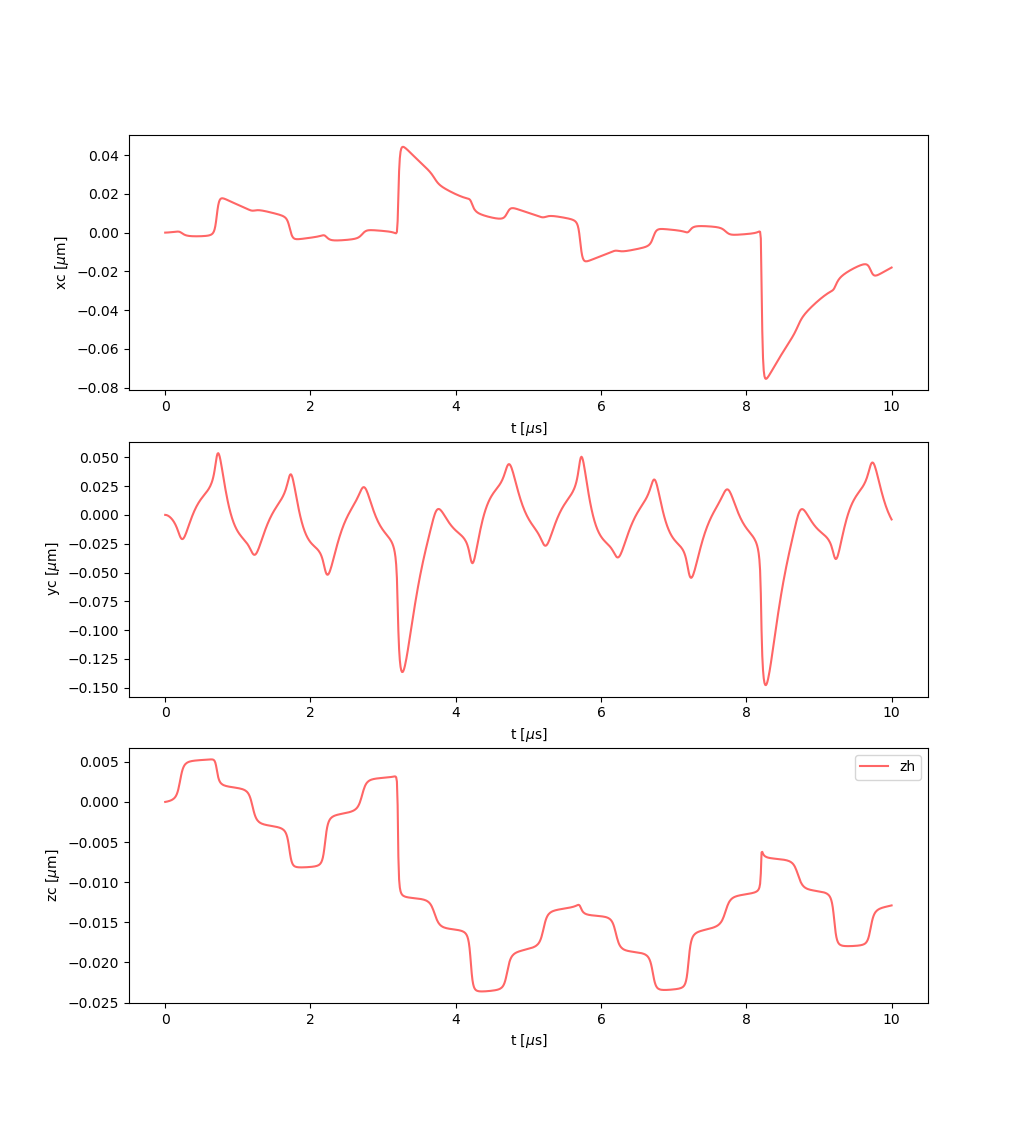

array([[ 1.00000000e-05, -5.00000000e-05,  2.00000000e-05,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.95562942e-06, -4.89020430e-05,  1.99937033e-05,
         8.22619312e-12, -5.11728224e-11,  1.43522051e-11],
       [ 9.82291232e-06, -4.76111914e-05,  1.99748189e-05,
         2.60927123e-11, -1.98527754e-10,  3.25916987e-11],
       ...,
       [ 1.04458365e-05, -5.14578650e-05,  1.97547611e-05,
        -1.84150576e-08, -1.48623021e-09, -1.29402762e-08],
       [ 1.07196892e-05, -5.08826144e-05,  1.99055565e-05,
        -1.82121912e-08, -2.75305638e-09, -1.29189456e-08],
       [ 1.08984130e-05, -5.01066464e-05,  2.00438156e-05,
        -1.80102207e-08, -3.95123269e-09, -1.28970687e-08]])

In [67]:
fig = plt.figure(figsize=(12,10))


ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(t*10**6, x_rk[:, 3]*10**6, color='red', alpha=0.6,label='xh')
ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(t*10**6, x_rk[:, 4]*10**6, color='red', alpha=0.6,label='yh')
ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(t*10**6, x_rk[:, 5]*10**6, color='red', alpha=0.6,label='zh')

ax1.set_xlabel('t [$\u03bc$s]')
ax1.set_ylabel('xc [$\u03bc$m]')

ax2.set_xlabel('t [$\u03bc$s]')
ax2.set_ylabel('yc [$\u03bc$m]')

ax3.set_xlabel('t [$\u03bc$s]')
ax3.set_ylabel('zc [$\u03bc$m]')
plt.legend(loc='best')
plt.show()
x_rk

<IPython.core.display.Javascript object>


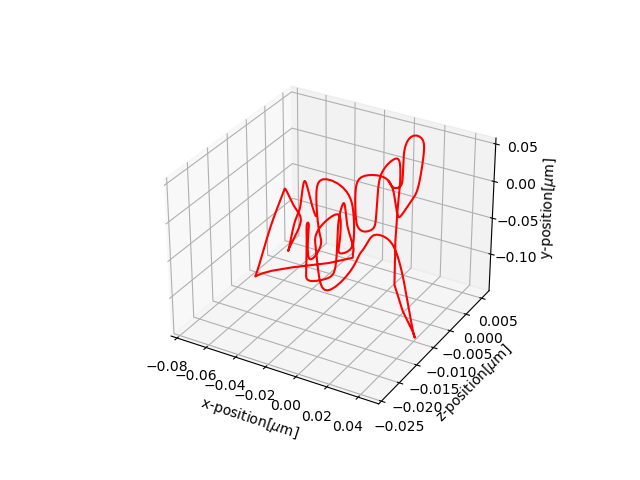

In [63]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot( x_rk[:, 3]*10**6,  x_rk[:, 5]*10**6, x_rk[:, 4]*10**6, color='red')
ax.set_xlabel('x-position[$\u03bc$m]')
ax.set_ylabel('z-position[$\u03bc$m]')
ax.set_zlabel('y-position[$\u03bc$m]')
plt.show()

In [52]:
def runge_kutta_method_v(n, t, dt, x_0, v_0, func):
    '''ルンゲクッタ法'''
    x = np.zeros((len(t), n))
    v = np.zeros((len(t), n))
    for i in range(len(t) - 1):
        if i == 0:
            x[i, :] = x_0
            v[i, :] = v_0
            
        k1_x = v[i, :] * dt
        k1_v = func(v[i, :], x[i, :]) * dt
        
        k2_x = (v[i, :] + k1_v / 2) * dt
        k2_v = func(v[i, :] + k1_v / 2, x[i, :] + k1_x / 2) * dt
        
        k3_x = (v[i, :] + k2_v / 2) * dt
        k3_v = func(v[i, :] + k2_v / 2, x[i, :] + k2_x / 2) * dt
        
        k4_x = (v[i, :] + k3_v) * dt
        k4_v = func(v[i, :] + k3_v, x[i, :] + k3_x) * dt
        
        x[i + 1, :] = x[i, :] + (k1_x + 2 * k2_x + 2 * k3_x + k4_x) / 6
        v[i + 1, :] = v[i, :] + (k1_v + 2 * k2_v + 2 * k3_v + k4_v) / 6
    return v
v_rk = runge_kutta_method_v(n, t, dt, x_0, v_0, func)

<IPython.core.display.Javascript object>


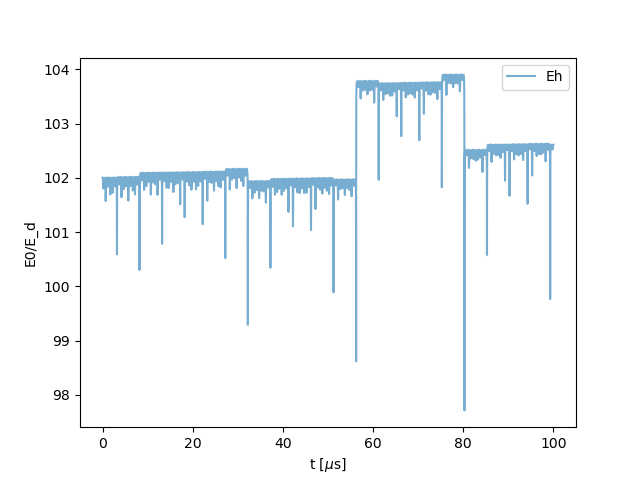

In [53]:
# プロット
fig = plt.figure()

E_d=4.3*10**(-23)
Th=mh*(v_rk[:, 0]**2+v_rk[:, 1]**2+v_rk[:, 2]**2)
Uh=mh*(whx**2*x_rk[:,0]**2+why**2*x_rk[:,1]**2+whz**2*x_rk[:,2]**2)
ax1 = fig.add_subplot()
ax1.plot(t*10**6, (Th+Uh)/(2*E_d), alpha=0.6,label='Eh')


ax1.set_xlabel('t [$\u03bc$s]')
ax1.set_ylabel('E0/E_d')



plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


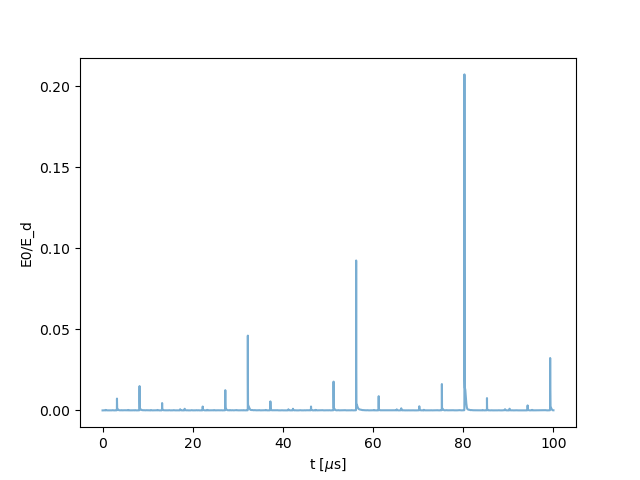

In [54]:
# プロット
fig = plt.figure()

E_d=4.3*10**(-23)
Tc=mh*(v_rk[:, 3]**2+v_rk[:, 4]**2+v_rk[:, 5]**2)
Uc=mh*(whx**2*x_rk[:,3]**2+why**2*x_rk[:,4]**2+whz**2*x_rk[:,5]**2)
ax1 = fig.add_subplot()
ax1.plot(t*10**6, (Tc+Uc)/(2*E_d), alpha=0.6,label='Ec')


ax1.set_xlabel('t [$\u03bc$s]')
ax1.set_ylabel('E0/E_d')




plt.show()


<IPython.core.display.Javascript object>


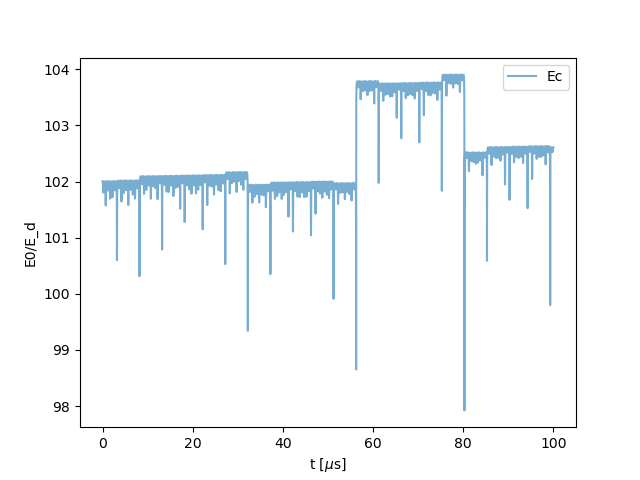

In [55]:
# プロット
fig = plt.figure()

E_d=4.3*10**(-23)

ax1 = fig.add_subplot()
ax1.plot(t*10**6, (Tc+Uc+Th+Uh)/(2*E_d), alpha=0.6,label='Ec')


ax1.set_xlabel('t [$\u03bc$s]')
ax1.set_ylabel('E0/E_d')



ax3.set_xlabel('t [$\u03bc$s]')
ax3.set_ylabel('zh [$\u03bc$m]')
plt.legend(loc='best')
plt.show()
